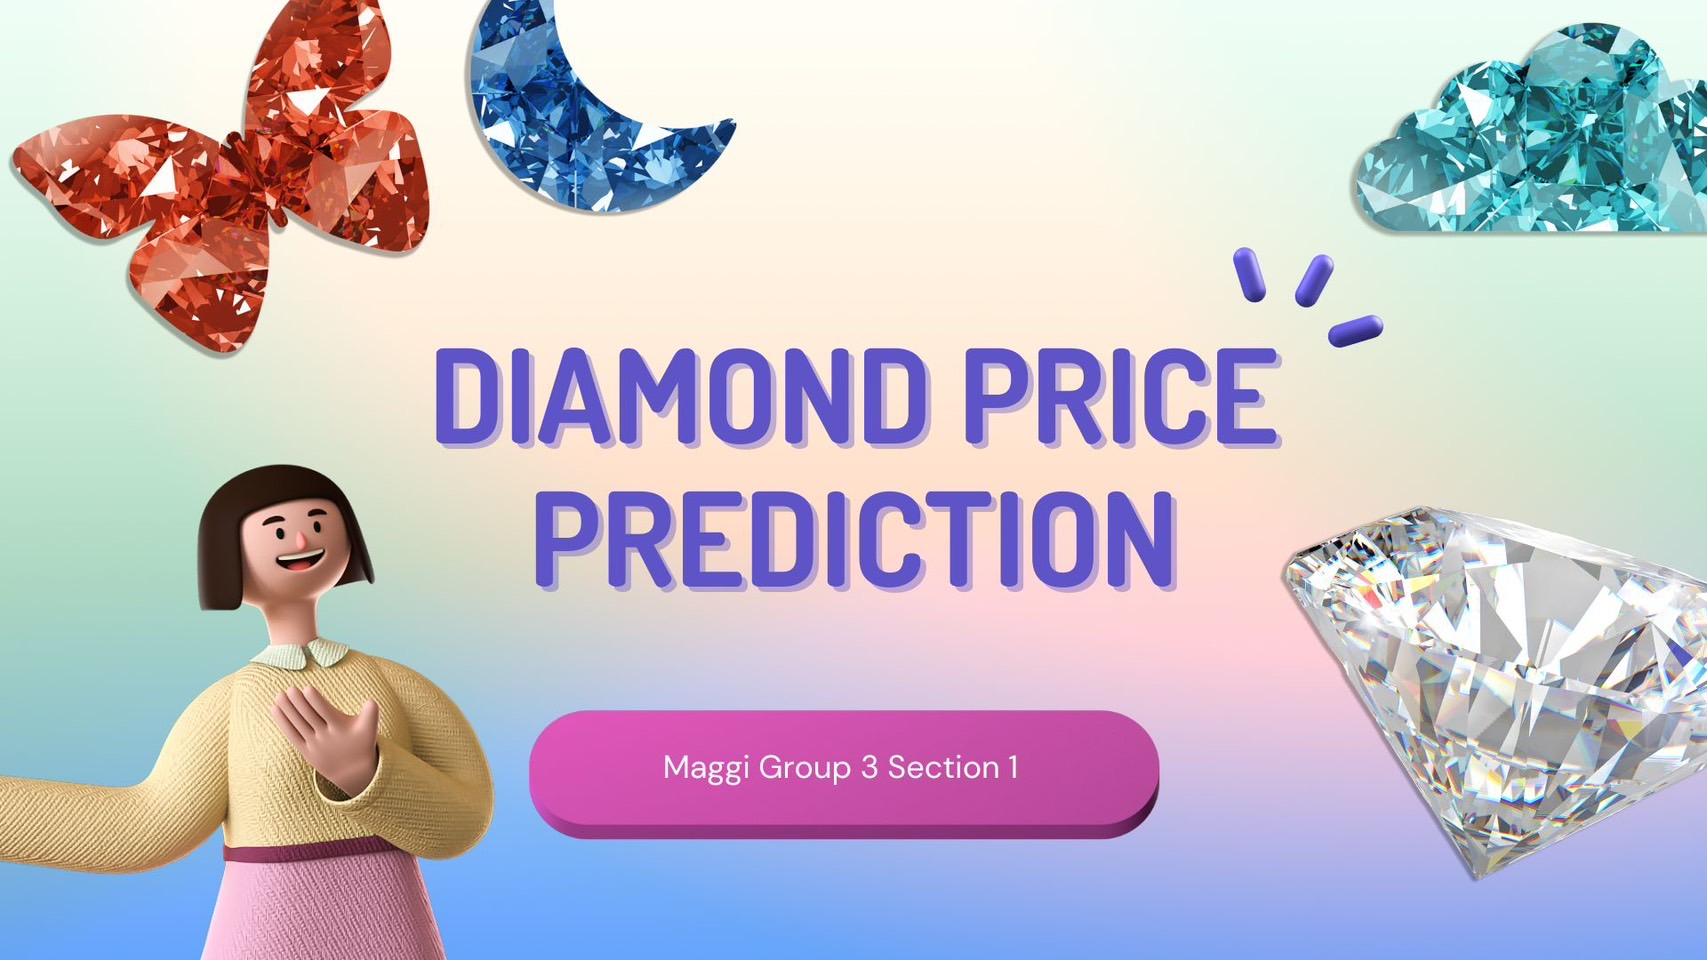

# Objective

1. ทายราคาเพชรต่อ 1 กะรัต ppc (price per carat) ในช่วงประมาณ 1,000 - 17,000 usd โดยวัดค่าความผิดพลาดจาก MAPE

2. เปรียบเทียบความผิดพลาดของ Model ระหว่าง Desicion Tree Regressor กับ K-Nearest Neighbor Regressor ในการทายราคาเพชรต่อ 1 กะรัต

3. เปรียบเทียบความผิดพลาดของ Model ที่ train ด้วยข้อมูลแบบ Imbalanced Data กับ Balanced Data ในการทายราคาเพชรต่อ 1 กะรัต

# Import

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
!pip install imbalanced-learn

from pandas.plotting import scatter_matrix

from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV
from scipy.stats import randint

from sklearn.preprocessing import MinMaxScaler

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn import metrics

# Variable    Definition

<b>carat</b> - a measure of diamond weight. (1 carat = 0.2 grams)

<b>clarity</b> - clearness of a diamond. The fewer and less noticeable a diamond’s imperfections, the better its clarity. Clarity contains 8 ordered levels, from “I1” (the worst) to “IF” (the best).
>I1 = 1<br>
>SI2 = 2<br>
>SI1 = 3<br>
>VS2 = 4<br>
>VS1 = 5<br>
>VVS2 = 6<br>
>VVS1 = 7<br>
>IF = 8

<b>color</b> - a color of the diamond in percentage, which colorless diamonds are considered better than diamonds with a yellow tint. There are 7 different colors contain;

A very faint color diamonds
>“J” = 0.94<br>
 “I” = 0.95<br>
 “H” = 0.96<br>
 “G” = 0.97

Colorless diamonds
>“F” = 0.98<br>
 “E” = 0.99<br>
 “D” = 1.00<br>


<b>cut</b> - quality of the cut to transfer a rough diamond into a finished diamond. There are 5 cut grades contain;
>Fair = 1<br>
>Good = 2<br>
>Very Good = 3<br>
>Premium = 4<br>
>Ideal = 5

<b>x</b> - length of the diamond in millimeters.

<b>y</b> - diameter or width of the diamond in millimeters.

<b>z</b> - depth of the diamond in millimeters.

<b>depth</b> - the total depth in millimeters ,which is measured from the table until the culet. It calculated from z/mean(x,y) = z*2/(x+y)

<b>table</b> - percentage of the width of diamond’s top(“table” in the figure) relative to widest point(diameter).

<b>price</b> - price of the diamond in US dollars,  which divided into 20 groups.


<b>Measurement of a diamond’s size</b>

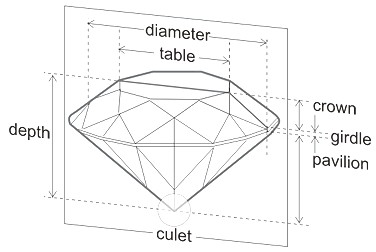




In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/ML/diamonds.csv')

Mounted at /content/drive


In [ ]:
#move column 'price' to the end
df = df[[col for col in df.columns if col != 'price'] + ['price']]

In [ ]:
df.head()

carat      cut color clarity  depth  table     x     y     z  price
0   0.23    Ideal     E     SI2   61.5   55.0  3.95  3.98  2.43    326
1   0.21  Premium     E     SI1   59.8   61.0  3.89  3.84  2.31    326
2   0.23     Good     E     VS1   56.9   65.0  4.05  4.07  2.31    327
3   0.29  Premium     I     VS2   62.4   58.0  4.20  4.23  2.63    334
4   0.31     Good     J     SI2   63.3   58.0  4.34  4.35  2.75    335

# Exploratory Data Analysis & Pre-Processing

In [ ]:
print(df.shape)
print(df.info())
print(df.isnull().sum())

(53940, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   x        53940 non-null  float64
 7   y        53940 non-null  float64
 8   z        53940 non-null  float64
 9   price    53940 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64


In [ ]:
print(df.duplicated().sum())
df = df.drop_duplicates()
print(df.duplicated().sum())
print(df.shape)

146
0
(53794, 10)


In [ ]:
df = df.drop(df[df["x"]==0].index)
df = df.drop(df[df["y"]==0].index)
df = df.drop(df[df["z"]==0].index)
print(df.shape)

(53775, 10)


In [ ]:
df.describe()

carat         depth         table             x             y  \
count  53775.000000  53775.000000  53775.000000  53775.000000  53775.000000   
mean       0.797536     61.748232     57.457806      5.731579      5.734909   
std        0.473169      1.429639      2.233257      1.118611      1.139451   
min        0.200000     43.000000     43.000000      3.730000      3.680000   
25%        0.400000     61.000000     56.000000      4.710000      4.720000   
50%        0.700000     61.800000     57.000000      5.700000      5.710000   
75%        1.040000     62.500000     59.000000      6.540000      6.540000   
max        5.010000     79.000000     95.000000     10.740000     58.900000   

                  z         price  
count  53775.000000  53775.000000  
mean       3.539964   3931.220288  
std        0.702017   3985.918716  
min        1.070000    326.000000  
25%        2.910000    951.000000  
50%        3.530000   2401.000000  
75%        4.030000   5324.000000  
max       31.800000  18823.000000

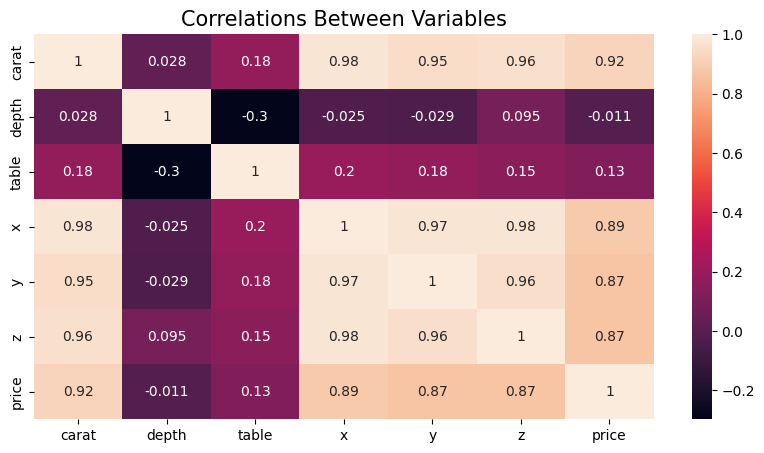

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),annot=True)
plt.title("Correlations Between Variables",size=15)
plt.show()

In [ ]:
# high correlation between carat and x,y,z
df = df.drop(columns = 'x')
df = df.drop(columns = 'y')
df = df.drop(columns = 'z')

In [ ]:
df['ppc'] = df['price']/df['carat']

In [ ]:
df_ppc = df.drop(columns = 'price')
y_price = df[['price']]

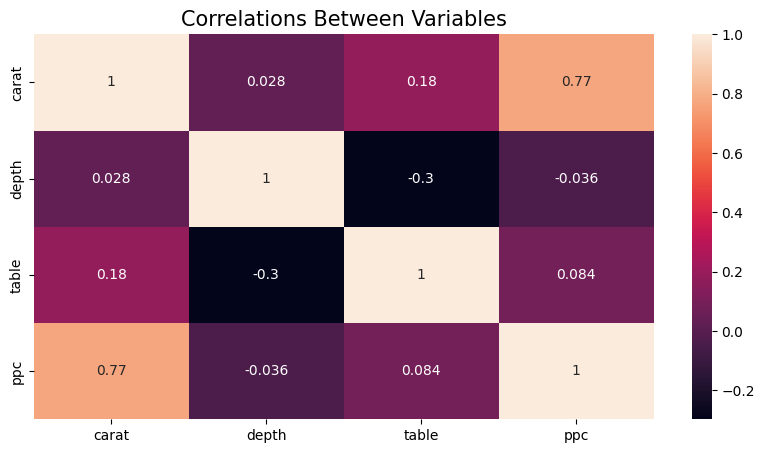

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(df_ppc.corr(),annot=True)
plt.title("Correlations Between Variables",size=15)
plt.show()

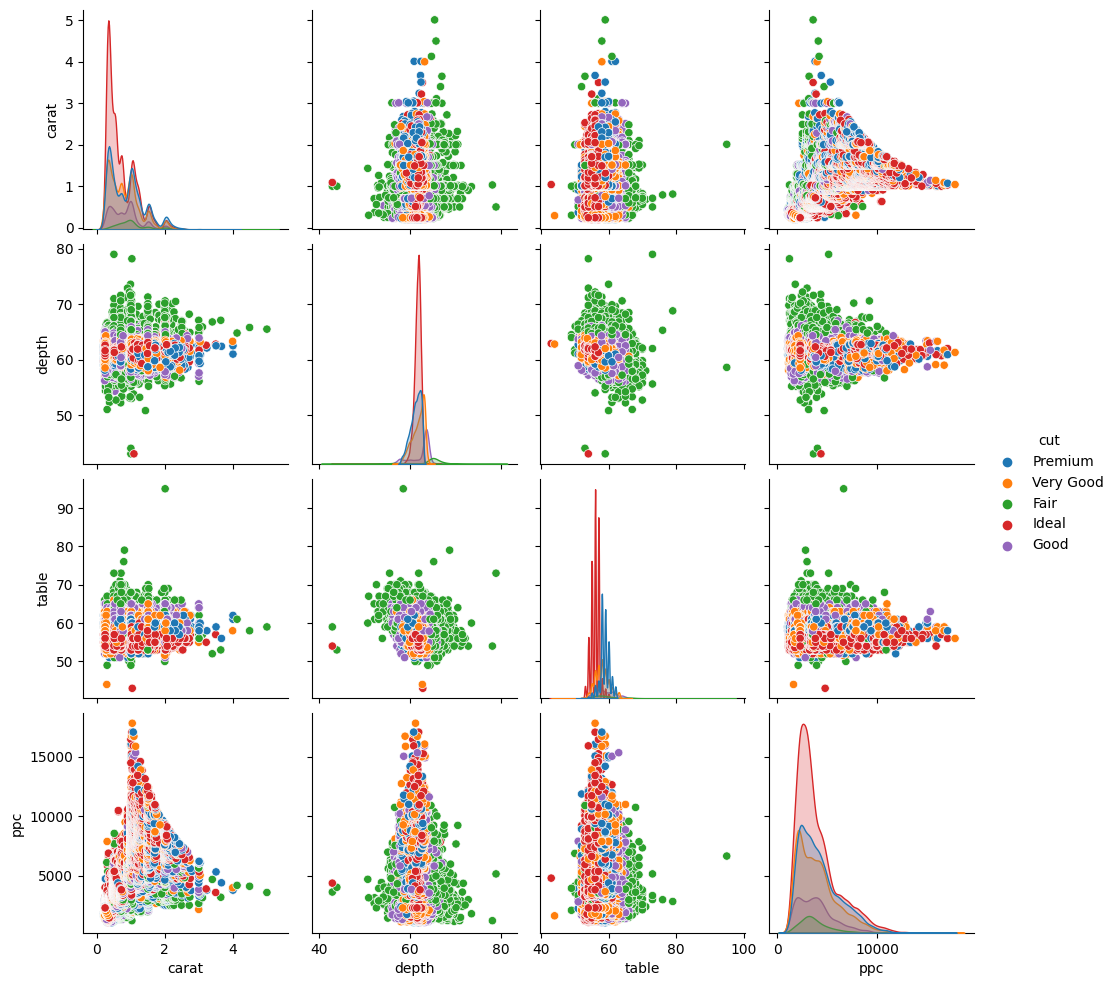

In [ ]:
ax=sns.pairplot(df_ppc, hue= "cut")
plt.show()

In [ ]:
x = df_ppc.drop(columns = 'ppc')
y = df_ppc[['ppc']]

<Axes: >

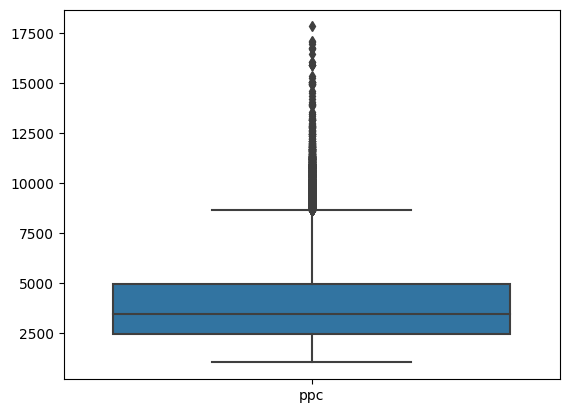

In [ ]:
sns.boxplot(data=y)

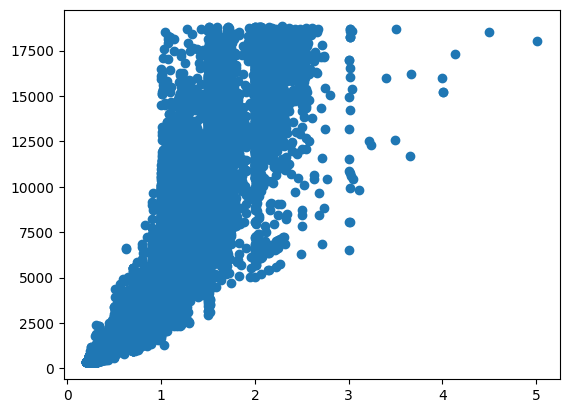

In [ ]:
plt.scatter(df['carat'],df['price'])
plt.show()

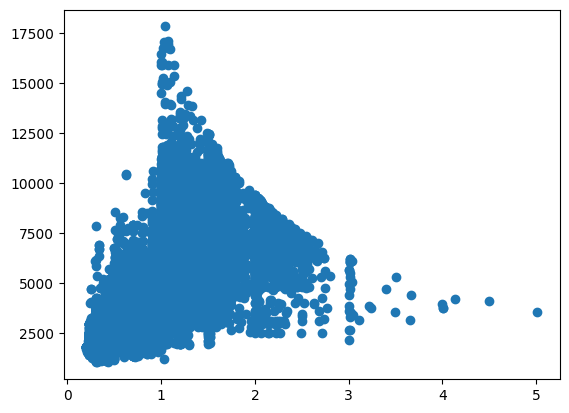

In [ ]:
plt.scatter(df_ppc['carat'],df_ppc['ppc'])
plt.show()

<Axes: >

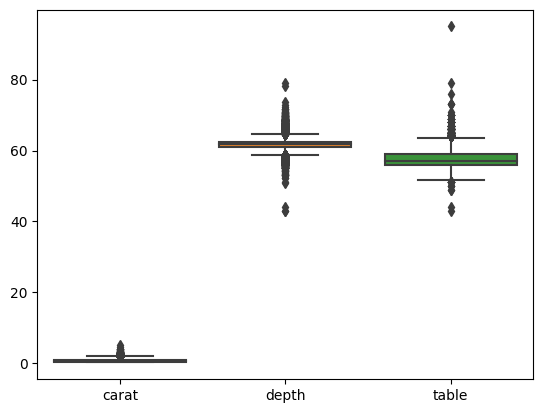

In [ ]:
sns.boxplot(data=x)

In [ ]:
# calculate IQR for column Height
Q1 = df['carat'].quantile(0.25)
Q3 = df['carat'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outliers = df[(df['carat'] < Q1 - threshold * IQR) | (df['carat'] > Q3 + threshold * IQR)]

outliers
# drop rows containing outliers
print(str(len(outliers)))
df = df.drop(outliers.index)

1867


In [ ]:
# calculate IQR for column Height
Q1 = df['depth'].quantile(0.25)
Q3 = df['depth'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outliers = df[(df['depth'] < Q1 - threshold * IQR) | (df['depth'] > Q3 + threshold * IQR)]

outliers
# drop rows containing outliers
print(str(len(outliers)))
df = df.drop(outliers.index)

2777


In [ ]:
# calculate IQR for column Height
Q1 = df['table'].quantile(0.25)
Q3 = df['table'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outliers = df[(df['table'] < Q1 - threshold * IQR) | (df['table'] > Q3 + threshold * IQR)]

outliers
# drop rows containing outliers
print(str(len(outliers)))
df = df.drop(outliers.index)

342


In [ ]:
# calculate IQR for column Height
Q1 = df['ppc'].quantile(0.25)
Q3 = df['ppc'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outliers = df[(df['ppc'] < Q1 - threshold * IQR) | (df['ppc'] > Q3 + threshold * IQR)]

outliers
# drop rows containing outliers
print(str(len(outliers)))
df = df.drop(outliers.index)

1929


In [ ]:
df_ppc = df.drop(columns = 'price')
y_price = df[['price']]

In [ ]:
x = df_ppc.drop(columns = 'ppc')
y = df_ppc[['ppc']]

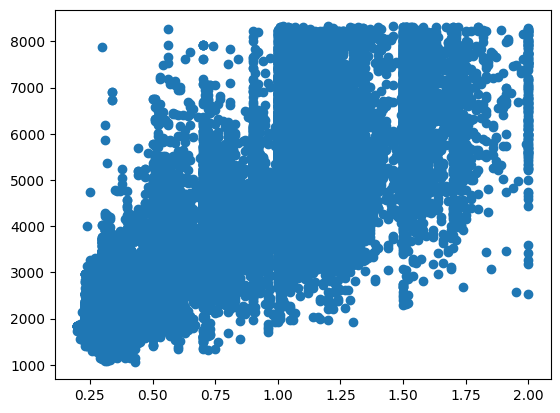

In [ ]:
plt.scatter(df_ppc['carat'],df_ppc['ppc'])
plt.show()

<Axes: >

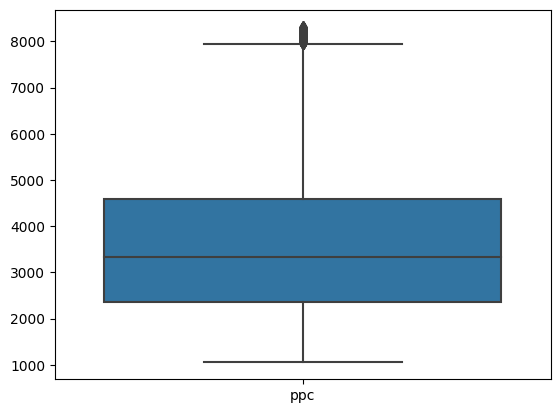

In [ ]:
sns.boxplot(data=y)

<Axes: >

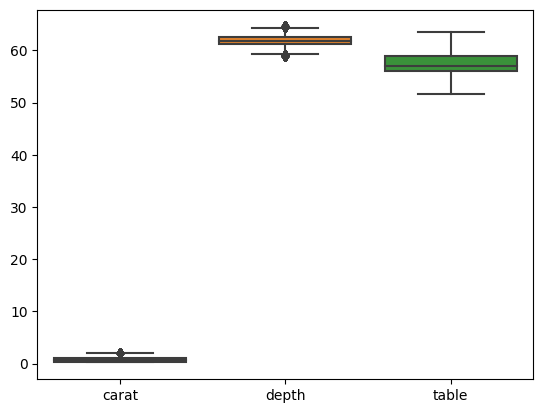

In [ ]:
sns.boxplot(data=x)

In [ ]:
df.describe()
# min 1051.16 usd ประมาณ 37,400 baht
# mean 3667.29 usd ประมาณ 130,300 baht
# max 8322.60 usd ประมาณ 295,700 baht

carat         depth         table         price           ppc
count  46860.000000  46860.000000  46860.000000  46860.000000  46860.000000
mean       0.714311     61.805301     57.254202   3119.776504   3667.291655
std        0.385085      1.079652      2.017765   2833.953393   1589.852178
min        0.200000     59.000000     51.600000    326.000000   1051.162791
25%        0.380000     61.200000     56.000000    886.000000   2368.750000
50%        0.600000     61.900000     57.000000   2043.000000   3333.333333
75%        1.010000     62.500000     59.000000   4603.250000   4595.555556
max        2.000000     64.600000     63.500000  16580.000000   8322.602740

In [ ]:
print(df.shape)
print(46860/53940)

# 46860/53940 = 86.87%

(46860, 8)
0.8687430478309233


In [ ]:
mappingcla = {'I1':1,"SI2":2,"SI1":3,"VS2":4,"VS1":5,"VVS2":6,"VVS1":7,"IF":8}
df['nclarity']=df['clarity'].map(mappingcla)

mappingcut = {'Fair':1,'Good':2,'Very Good':3,'Premium':4,'Ideal':5}
df['ncut']=df['cut'].map(mappingcut)

mappingcolor ={'D':1.00,'E':0.99,'F':0.98,'G':0.97,'H':0.96,'I':0.95,'J':0.94}
df['ncolor']=df['color'].map(mappingcolor)

ndf = df.drop(columns =['cut','color','clarity'])

ndf = ndf[[col for col in ndf.columns if col != 'price'] + ['price']]

In [ ]:
df_ppc = df.drop(columns = 'price')
y_price = df[['price']]

In [ ]:
ndf_ppc = ndf.drop(columns = 'price')
y_price = ndf[['price']]

In [ ]:
x = ndf_ppc.drop(columns = 'ppc')
y = ndf_ppc[['ppc']]

In [ ]:
#move column 'ppc' to the end
ndf_ppc = ndf_ppc[[col for col in ndf_ppc.columns if col != 'ppc'] + ['ppc']]

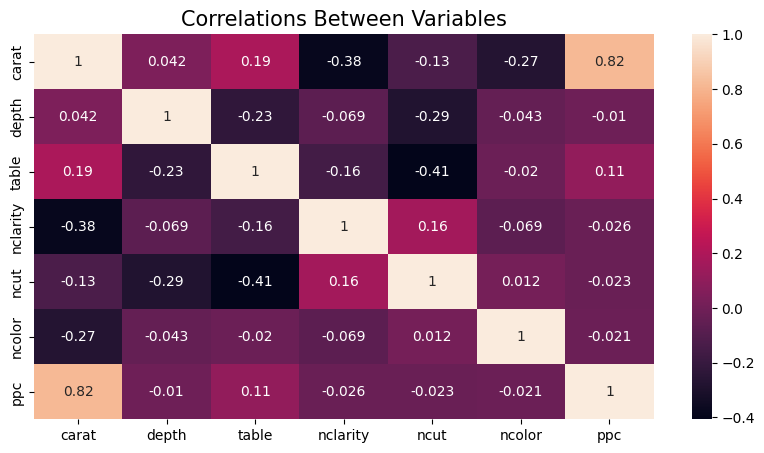

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(ndf_ppc.corr(),annot=True)
plt.title("Correlations Between Variables",size=15)
plt.show()

In [ ]:
ndf_ppc.describe()

carat         depth         table      nclarity          ncut  \
count  46860.000000  46860.000000  46860.000000  46860.000000  46860.000000   
mean       0.714311     61.805301     57.254202      4.091229      4.020060   
std        0.385085      1.079652      2.017765      1.625394      1.013946   
min        0.200000     59.000000     51.600000      1.000000      1.000000   
25%        0.380000     61.200000     56.000000      3.000000      3.000000   
50%        0.600000     61.900000     57.000000      4.000000      4.000000   
75%        1.010000     62.500000     59.000000      5.000000      5.000000   
max        2.000000     64.600000     63.500000      8.000000      5.000000   

             ncolor           ppc  
count  46860.000000  46860.000000  
mean       0.974399   3667.291655  
std        0.016893   1589.852178  
min        0.940000   1051.162791  
25%        0.960000   2368.750000  
50%        0.970000   3333.333333  
75%        0.990000   4595.555556  
max        1.000000   8322.602740

(array([1051.1627907 , 1414.73478815, 1778.3067856 , 2141.87878305,
        2505.4507805 , 2869.02277795, 3232.59477541, 3596.16677286,
        3959.73877031, 4323.31076776, 4686.88276521, 5050.45476266,
        5414.02676011, 5777.59875757, 6141.17075502, 6504.74275247,
        6868.31474992, 7231.88674737, 7595.45874482, 7959.03074227,
        8322.60273973]),
 array([ 622., 2921., 4241., 5283., 4618., 4411., 4181., 3349., 3356.,
        2817., 2501., 1679., 1275., 1167., 1046.,  886.,  758.,  683.,
         579.,  487.]))

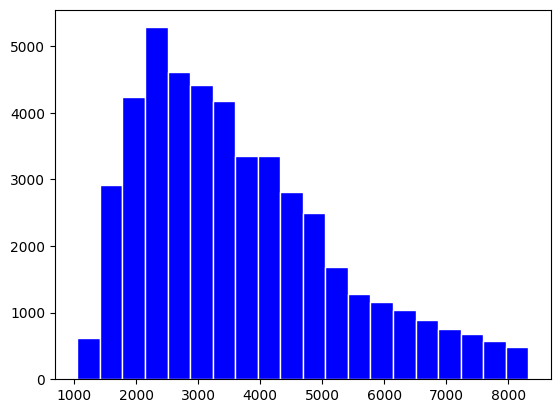

In [ ]:
n, bins, patches = plt.hist(y['ppc'], bins=20,color='blue', ec='white')
bins, n

In [ ]:
print(x.head())

   carat  depth  table  nclarity  ncut  ncolor
0   0.32   60.9   58.0         1     4    0.99
1   1.17   60.2   61.0         1     3    0.94
2   1.01   61.8   60.0         1     4    0.98
3   1.01   64.5   58.0         1     1    0.99
4   0.96   60.7   55.0         1     5    0.98


In [ ]:
print(y.head())

           ppc
0  1078.125000
1  2370.940171
2  2753.465347
3  2760.396040
4  2917.708333


# Split training data and test data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,train_size=0.8, random_state=1234)
print('training set = {} records, test set= {} records'.format(x_train.shape[0],x_test.shape[0]))

training set = 37488 records, test set= 9372 records


(array([1051.1627907 , 1414.73478815, 1778.3067856 , 2141.87878305,
        2505.4507805 , 2869.02277795, 3232.59477541, 3596.16677286,
        3959.73877031, 4323.31076776, 4686.88276521, 5050.45476266,
        5414.02676011, 5777.59875757, 6141.17075502, 6504.74275247,
        6868.31474992, 7231.88674737, 7595.45874482, 7959.03074227,
        8322.60273973]),
 array([ 499., 2315., 3336., 4227., 3692., 3554., 3373., 2673., 2642.,
        2271., 2011., 1341., 1020.,  931.,  855.,  702.,  616.,  568.,
         480.,  382.]))

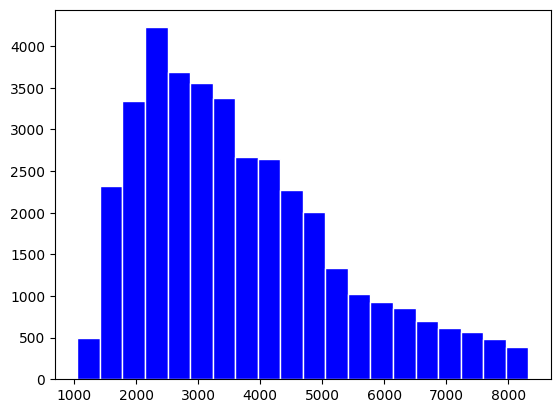

In [ ]:
n, bins, patches = plt.hist(y_train['ppc'], bins=20,color='blue', ec='white')
bins, n

(array([1138.70967742, 1497.90164453, 1857.09361164, 2216.28557875,
        2575.47754586, 2934.66951297, 3293.86148008, 3653.05344719,
        4012.24541429, 4371.4373814 , 4730.62934851, 5089.82131562,
        5449.01328273, 5808.20524984, 6167.39721695, 6526.58918406,
        6885.78115117, 7244.97311828, 7604.16508539, 7963.3570525 ,
        8322.54901961]),
 array([202., 699., 866., 973., 954., 877., 777., 665., 653., 548., 482.,
        334., 249., 201., 218., 164., 148., 121., 123., 118.]))

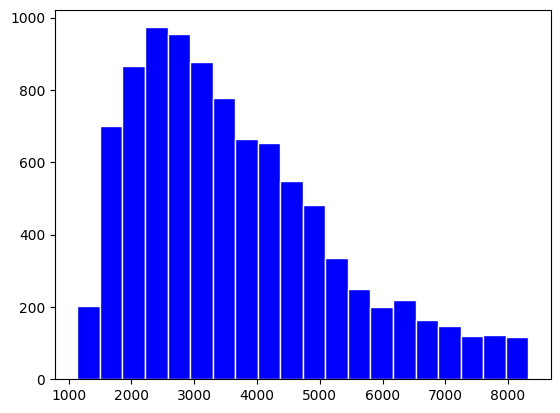

In [ ]:
n, bins, patches = plt.hist(y_test['ppc'], bins=20,color='blue', ec='white')
bins, n

# Modeling Before Undersampling

## Decision tree Regressor

In [ ]:
featurename = x_train.columns

In [ ]:
def Tree_visulization(tree,feature_names = featurename,class_names = 'ppc'):
    from six import StringIO
    from sklearn.tree import export_graphviz
    from IPython.display import Image
    import pydotplus

    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data,
                    feature_names = featurename,
                    class_names = y,
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.set_size('"100,100!"')
    return Image(graph.create_png())

In [ ]:
model_dt = DecisionTreeRegressor(criterion='absolute_error',
                                 splitter='best',
                                 random_state=1234)
model_dt.fit(x_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', random_state=1234)

In [ ]:
text_representation = tree.export_text(model_dt,
                                       feature_names=list(featurename))
print(text_representation)

# maxdepth  = 11+29 = 40

|--- carat <= 0.69
|   |--- carat <= 0.50
|   |   |--- nclarity <= 5.50
|   |   |   |--- nclarity <= 3.50
|   |   |   |   |--- ncolor <= 0.98
|   |   |   |   |   |--- carat <= 0.38
|   |   |   |   |   |   |--- ncolor <= 0.95
|   |   |   |   |   |   |   |--- nclarity <= 2.50
|   |   |   |   |   |   |   |   |--- carat <= 0.34
|   |   |   |   |   |   |   |   |   |--- ncolor <= 0.94
|   |   |   |   |   |   |   |   |   |   |--- ncut <= 2.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1080.65]
|   |   |   |   |   |   |   |   |   |   |--- ncut >  2.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- ncolor >  0.94
|   |   |   |   |   |   |   |   |   |   |--- ncut <= 2.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- ncut >  2.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |

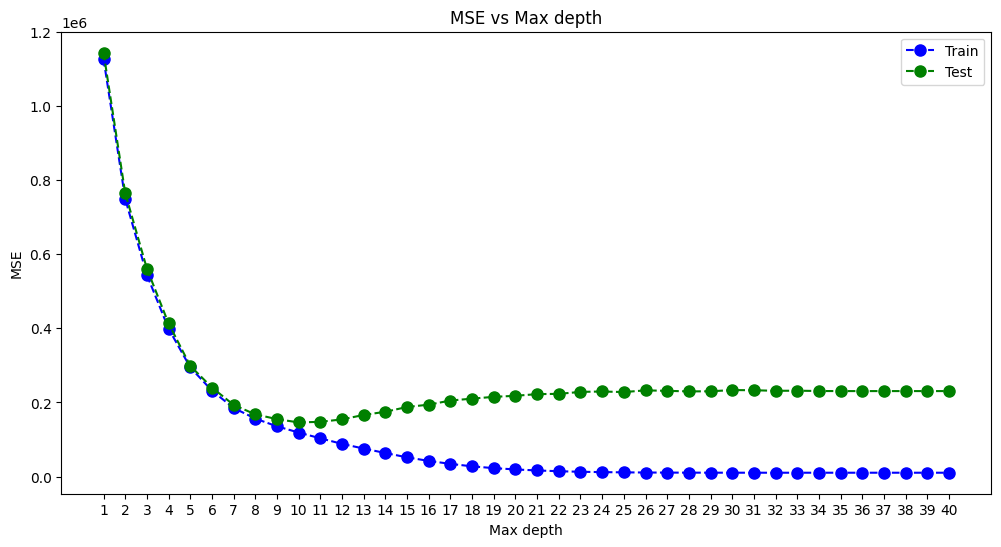

In [ ]:
max_depth_start = 1
max_depth_end = 40
mse_tr = []
mse_te = []

for i in range(max_depth_start, max_depth_end+1):
    dt = DecisionTreeRegressor(criterion='squared_error',
                               splitter='best',
                               random_state=1234,
                               max_depth=i)
    dt.fit(x_train, y_train)
    pred_i_tr = dt.predict(x_train)
    pred_i_te = dt.predict(x_test)
    mse_tr.append(metrics.mean_squared_error(y_train, pred_i_tr))
    mse_te.append(metrics.mean_squared_error(y_test, pred_i_te))

### Plot for testing max_depth that appropriate
plt.figure(figsize=(12, 6))
plt.plot(range(max_depth_start, max_depth_end+1), mse_tr, color='blue',
         linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=8,label="Train")
plt.plot(range(max_depth_start, max_depth_end+1), mse_te, color='green',
         linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=8,label="Test")
plt.legend()
plt.xticks(np.arange(max_depth_start, max_depth_end+1, 1))
plt.title('MSE vs Max depth')
plt.xlabel('Max depth')
plt.ylabel('MSE')
plt.show()

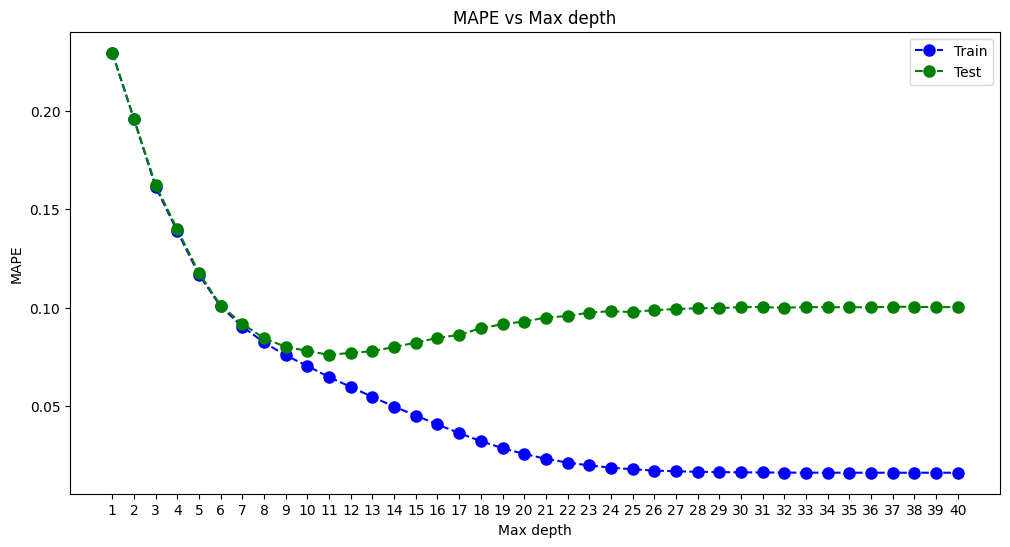

In [ ]:
max_depth_start = 1
max_depth_end = 40
mape_tr = []
mape_te = []

for i in range(max_depth_start, max_depth_end+1):
    dt = DecisionTreeRegressor(criterion='absolute_error',
                               splitter='best',
                               random_state=1234,
                               max_depth=i)
    dt.fit(x_train, y_train)
    pred_i_tr = dt.predict(x_train)
    pred_i_te = dt.predict(x_test)
    mape_tr.append(metrics.mean_absolute_percentage_error(y_train, pred_i_tr))
    mape_te.append(metrics.mean_absolute_percentage_error(y_test, pred_i_te))

### Plot for testing max_depth that appropriate
plt.figure(figsize=(12, 6))
plt.plot(range(max_depth_start, max_depth_end+1), mape_tr, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=8,label="Train")
plt.plot(range(max_depth_start, max_depth_end+1), mape_te, color='green', linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=8,label="Test")
plt.legend()
plt.xticks(np.arange(max_depth_start, max_depth_end+1, 1))
plt.title('MAPE vs Max depth')
plt.xlabel('Max depth')
plt.ylabel('MAPE')
plt.show()

#choose 3-8

In [ ]:
model_dt = DecisionTreeRegressor(criterion='absolute_error',
                                 splitter='best', random_state=1234)

In [ ]:
# Hyper parameters range intialization for tuning
parameters={"max_depth" : [3,4,5,6,7,8],
            "min_samples_split":[375,750,1125,1500,1875],
            "min_samples_leaf":[375,750,1125,1500,1875],
            }

In [ ]:
random_search1 = RandomizedSearchCV(
    model_dt,
    param_distributions =parameters,
    scoring='neg_mean_absolute_error',
    cv=5, verbose=3,
)

random_search1.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=8, min_samples_leaf=1875, min_samples_split=1500;, score=-550.623 total time=  18.7s
[CV 2/5] END max_depth=8, min_samples_leaf=1875, min_samples_split=1500;, score=-547.974 total time=  12.2s
[CV 3/5] END max_depth=8, min_samples_leaf=1875, min_samples_split=1500;, score=-564.834 total time=  11.3s
[CV 4/5] END max_depth=8, min_samples_leaf=1875, min_samples_split=1500;, score=-557.211 total time=  11.3s
[CV 5/5] END max_depth=8, min_samples_leaf=1875, min_samples_split=1500;, score=-549.762 total time=  12.2s
[CV 1/5] END max_depth=3, min_samples_leaf=1875, min_samples_split=1875;, score=-584.642 total time=  10.8s
[CV 2/5] END max_depth=3, min_samples_leaf=1875, min_samples_split=1875;, score=-586.327 total time=  10.7s
[CV 3/5] END max_depth=3, min_samples_leaf=1875, min_samples_split=1875;, score=-602.423 total time=  11.7s
[CV 4/5] END max_depth=3, min_samples_leaf=1875, min_samples_split=1875;, s

RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeRegressor(criterion='absolute_error',
                                                   random_state=1234),
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8],
                                        'min_samples_leaf': [375, 750, 1125,
                                                             1500, 1875],
                                        'min_samples_split': [375, 750, 1125,
                                                              1500, 1875]},
                   scoring='neg_mean_absolute_error', verbose=3)

In [ ]:
# best hyperparameters
print("Best parameters: ", random_search1.best_params_)
print("Best score: ", random_search1.best_score_)
print("Average score: ",random_search1.cv_results_['mean_test_score'].mean())

Best parameters:  {'min_samples_split': 1125, 'min_samples_leaf': 1125, 'max_depth': 5}
Best score:  -480.74755521916995
Average score:  -543.3120892860546


In [ ]:
#round 1
model_dt_final = DecisionTreeRegressor(criterion='absolute_error',
                                       splitter='best',
                                       random_state= 1234,
                                       min_samples_split=1125,
                                       min_samples_leaf=1125,
                                       max_depth=5,)
model_dt_final.fit(x_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      min_samples_leaf=1125, min_samples_split=1125,
                      random_state=1234)

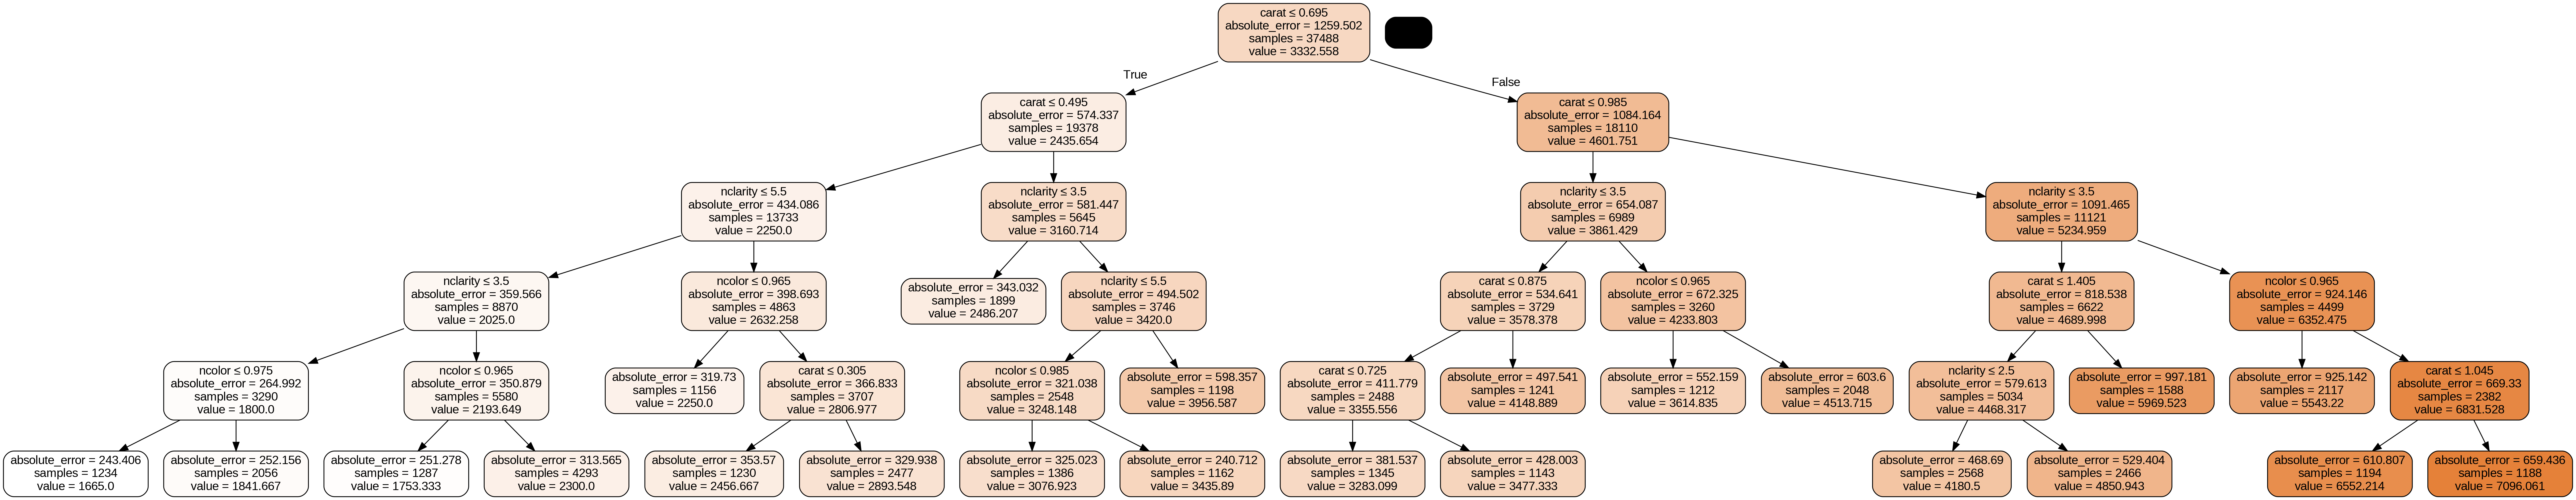

In [ ]:
Tree_visulization(model_dt_final)

In [ ]:
# Predict the labels for the test data using the best model
y_pred_train_dt = model_dt_final.predict(x_train)
y_pred_test_dt = model_dt_final.predict(x_test)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_train,y_pred_train_dt))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_train_dt))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_dt)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_train, y_pred_train_dt))

MAE: 461.41686707178144
MSE: 410699.62892419065
RMSE: 640.8585092859348
MAPE: 0.1294537916001262


In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test,y_pred_test_dt))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test_dt))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_dt)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred_test_dt))

MAE: 461.3488467417087
MSE: 414190.10276001034
RMSE: 643.5760271793927
MAPE: 0.12899700131502534


In [ ]:
print('Target classes of the first 10 rows are {}'.format(y_test.values[0:10]))
print('Predicted classes of the first 10 rows are {}'.format(y_pred_test_dt[0:10]))

Target classes of the first 10 rows are [[2190.32258065]
 [6461.76470588]
 [6055.55555556]
 [4145.05494505]
 [3852.27272727]
 [4657.14285714]
 [4284.15841584]
 [3086.20689655]
 [2719.60784314]
 [4399.0990991 ]]
Predicted classes of the first 10 rows are [2337.29946524 6552.21359223 4148.88888889 4148.88888889 4148.88888889
 3614.83516484 4031.79694138 3076.92307692 2486.20689655 4031.79694138]


In [ ]:
#round 2
random_search = RandomizedSearchCV(
    model_dt,
    param_distributions =parameters,
    scoring='neg_mean_absolute_error',
    cv=5, verbose=3,
)

random_search.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=5, min_samples_leaf=1125, min_samples_split=1875;, score=-480.004 total time=  16.3s
[CV 2/5] END max_depth=5, min_samples_leaf=1125, min_samples_split=1875;, score=-477.219 total time=  14.6s
[CV 3/5] END max_depth=5, min_samples_leaf=1125, min_samples_split=1875;, score=-484.804 total time=  13.9s
[CV 4/5] END max_depth=5, min_samples_leaf=1125, min_samples_split=1875;, score=-486.372 total time=  24.0s
[CV 5/5] END max_depth=5, min_samples_leaf=1125, min_samples_split=1875;, score=-475.339 total time=  12.9s
[CV 1/5] END max_depth=5, min_samples_leaf=750, min_samples_split=1125;, score=-442.517 total time=  12.8s
[CV 2/5] END max_depth=5, min_samples_leaf=750, min_samples_split=1125;, score=-434.233 total time=  11.8s
[CV 3/5] END max_depth=5, min_samples_leaf=750, min_samples_split=1125;, score=-441.450 total time=  13.0s
[CV 4/5] END max_depth=5, min_samples_leaf=750, min_samples_split=1125;, score

RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeRegressor(criterion='absolute_error',
                                                   random_state=1234),
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8],
                                        'min_samples_leaf': [375, 750, 1125,
                                                             1500, 1875],
                                        'min_samples_split': [375, 750, 1125,
                                                              1500, 1875]},
                   scoring='neg_mean_absolute_error', verbose=3)

In [ ]:
#round 2
# best hyperparameters
print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)
print("Average score: ",random_search.cv_results_['mean_test_score'].mean())

Best parameters:  {'min_samples_split': 750, 'min_samples_leaf': 750, 'max_depth': 7}
Best score:  -428.7205940461001
Average score:  -460.95823822029223


In [ ]:
#round 2
model_dt_final = DecisionTreeRegressor(criterion='absolute_error',
                                       splitter='best',
                                       random_state= 1234,
                                       min_samples_split=750,
                                       min_samples_leaf=750,
                                       max_depth=7,)
model_dt_final.fit(x_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                      min_samples_leaf=750, min_samples_split=750,
                      random_state=1234)

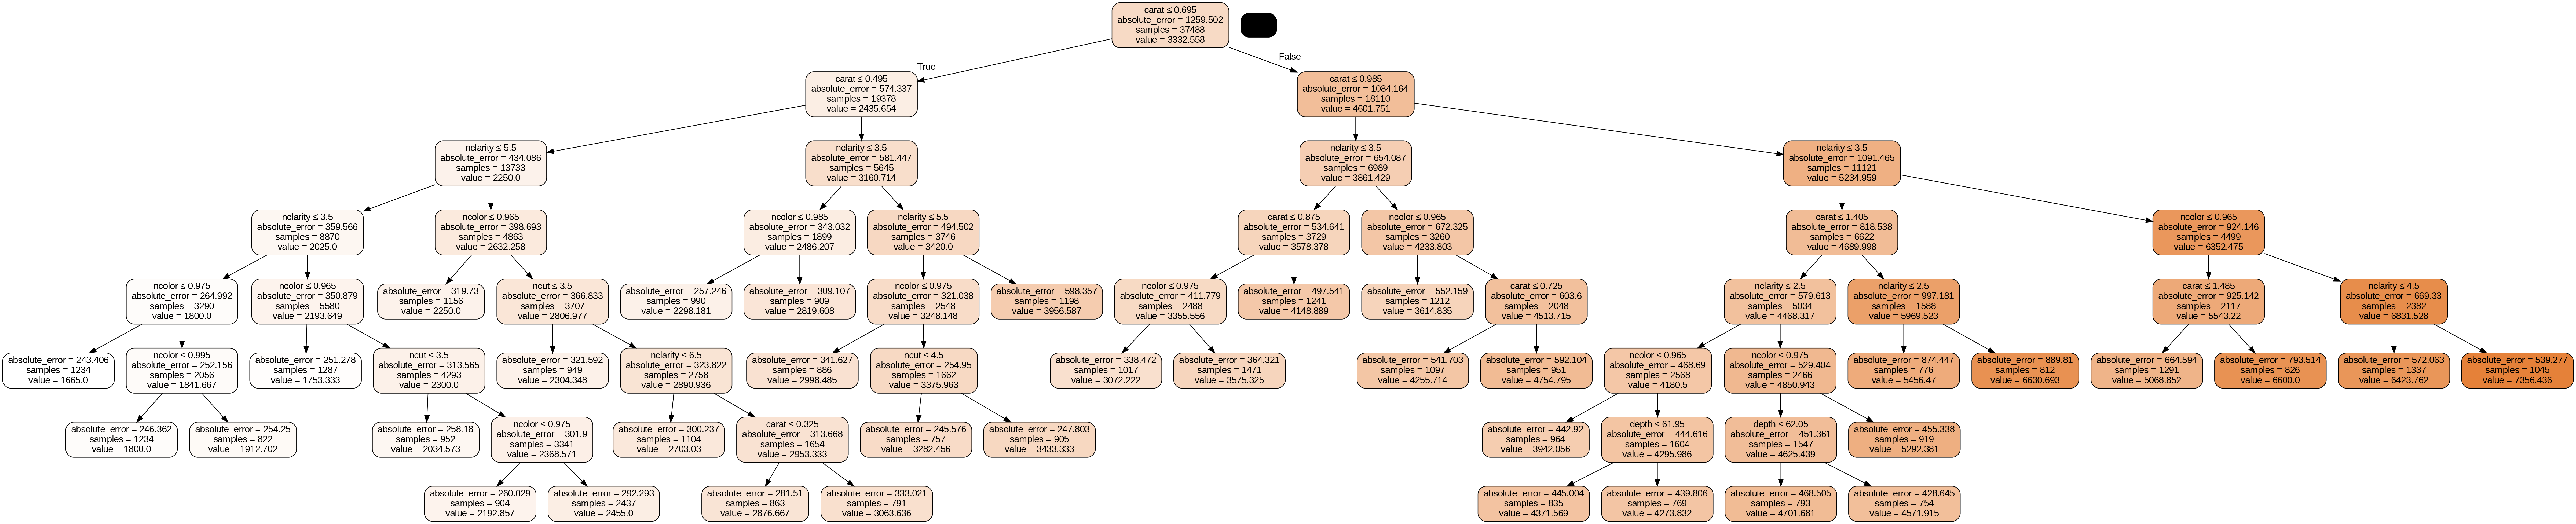

In [ ]:
Tree_visulization(model_dt_final)

In [ ]:
# Predict the labels for the test data using the best model
y_pred_train_dt = model_dt_final.predict(x_train)
y_pred_test_dt = model_dt_final.predict(x_test)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_train,y_pred_train_dt))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_train_dt))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_dt)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_train, y_pred_train_dt))

MAE: 416.79734602476117
MSE: 337291.83174011897
RMSE: 580.7683115839905
MAPE: 0.1183092244377633


In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test,y_pred_test_dt))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test_dt))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_dt)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred_test_dt))

MAE: 419.9243513905856
MSE: 343712.4127523329
RMSE: 586.269914589119
MAPE: 0.11872963902517372


In [ ]:
print('Target classes of the first 10 rows are {}'.format(y_test.values[0:10]))
print('Predicted classes of the first 10 rows are {}'.format(y_pred_test_dt[0:10]))

Target classes of the first 10 rows are [[2190.32258065]
 [6461.76470588]
 [6055.55555556]
 [4145.05494505]
 [3852.27272727]
 [4657.14285714]
 [4284.15841584]
 [3086.20689655]
 [2719.60784314]
 [4399.0990991 ]]
Predicted classes of the first 10 rows are [2034.57317073 6423.76237624 4148.88888889 4148.88888889 4148.88888889
 3614.83516484 4371.56862745 3433.33333333 2819.60784314 3942.05635948]


## K-Nearest Neighbor Regressor

### Normalization

In [ ]:
#x' = (x – min) / (max – min)

scaler = MinMaxScaler()
featurename = x.columns
xn_train = x_train
xn_test = x_test

for col in featurename:
  xn_train[col] = scaler.fit_transform(xn_train[[col]])

for col in featurename:
  xn_test[col] = scaler.fit_transform(xn_test[[col]])

In [ ]:
xn_train.describe()

carat         depth         table      nclarity          ncut  \
count  37488.000000  37488.000000  37488.000000  37488.000000  37488.000000   
mean       0.286680      0.500844      0.479629      0.441757      0.754808   
std        0.214229      0.192847      0.170737      0.232283      0.253477   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.100000      0.392857      0.372881      0.285714      0.500000   
50%        0.222222      0.517857      0.457627      0.428571      0.750000   
75%        0.450000      0.625000      0.627119      0.571429      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

             ncolor  
count  37488.000000  
mean       0.572810  
std        0.281461  
min        0.000000  
25%        0.333333  
50%        0.500000  
75%        0.833333  
max        1.000000

In [ ]:
xn_test.describe()

carat        depth        table     nclarity         ncut  \
count  9372.000000  9372.000000  9372.000000  9372.000000  9372.000000   
mean      0.281923     0.501359     0.455001     0.440994     0.755842   
std       0.212729     0.192598     0.176518     0.231875     0.253535   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.094444     0.375000     0.347826     0.285714     0.500000   
50%       0.216667     0.517857     0.434783     0.428571     0.750000   
75%       0.450000     0.625000     0.608696     0.571429     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            ncolor  
count  9372.000000  
mean      0.575384  
std       0.281883  
min       0.000000  
25%       0.333333  
50%       0.500000  
75%       0.833333  
max       1.000000

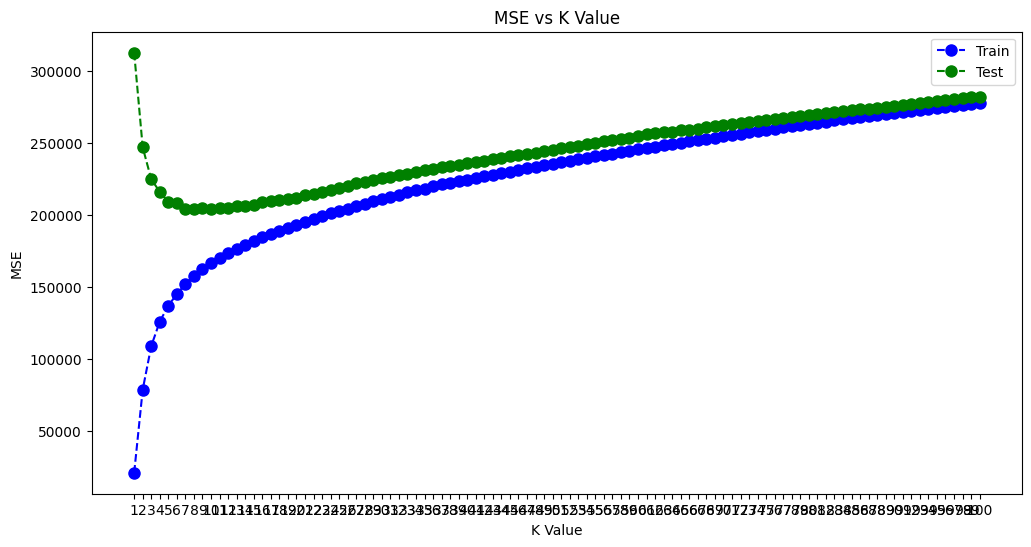

In [ ]:
K_start = 1
K_end = 100
mse_tr = []
mse_te = []
for i in range(K_start, K_end+1):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(xn_train, y_train)
    pred_i_tr = knn.predict(xn_train)
    pred_i_te = knn.predict(xn_test)
    mse_tr.append(metrics.mean_squared_error(y_train,pred_i_tr))
    mse_te.append(metrics.mean_squared_error(y_test,pred_i_te))

### Plot for testing k that appropriate
plt.figure(figsize=(12, 6))
plt.plot(range(K_start, K_end+1), mse_tr, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=8,label="Train")
plt.plot(range(K_start, K_end+1), mse_te, color='green', linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=8,label="Test")
plt.legend()
plt.xticks(np.arange(K_start, K_end+1, 1))
plt.title('MSE vs K Value')
plt.xlabel('K Value')
plt.ylabel('MSE')
plt.show()

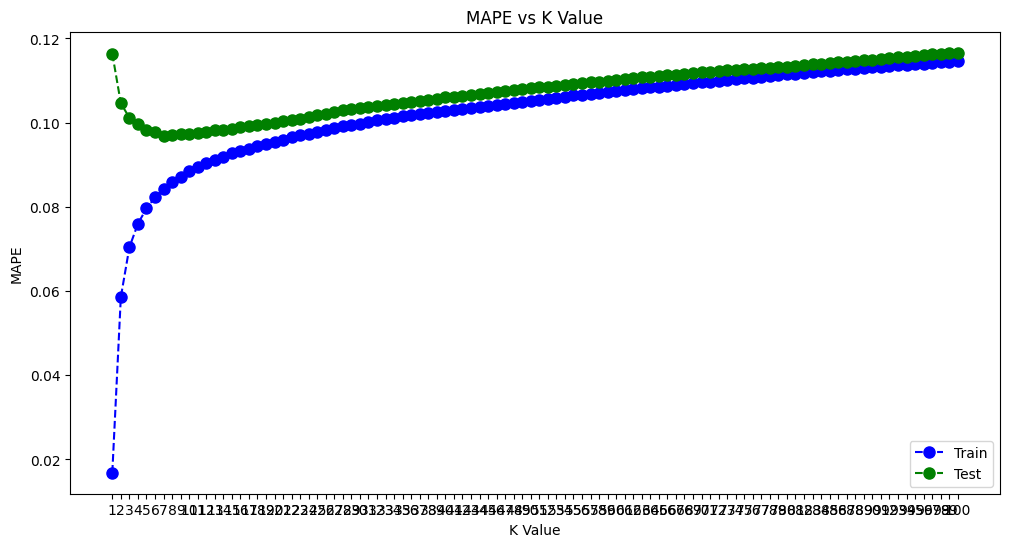

In [ ]:
K_start = 1
K_end = 100
mape_tr = []
mape_te = []
for i in range(K_start, K_end+1):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(xn_train, y_train)
    pred_i_tr = knn.predict(xn_train)
    pred_i_te = knn.predict(xn_test)
    mape_tr.append(metrics.mean_absolute_percentage_error(y_train,pred_i_tr))
    mape_te.append(metrics.mean_absolute_percentage_error(y_test,pred_i_te))

### Plot for testing k that appropriate
plt.figure(figsize=(12, 6))
plt.plot(range(K_start, K_end+1), mape_tr, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=8,label="Train")
plt.plot(range(K_start, K_end+1), mape_te, color='green', linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=8,label="Test")
plt.legend()
plt.xticks(np.arange(K_start, K_end+1, 1))
plt.title('MAPE vs K Value')
plt.xlabel('K Value')
plt.ylabel('MAPE')
plt.show()

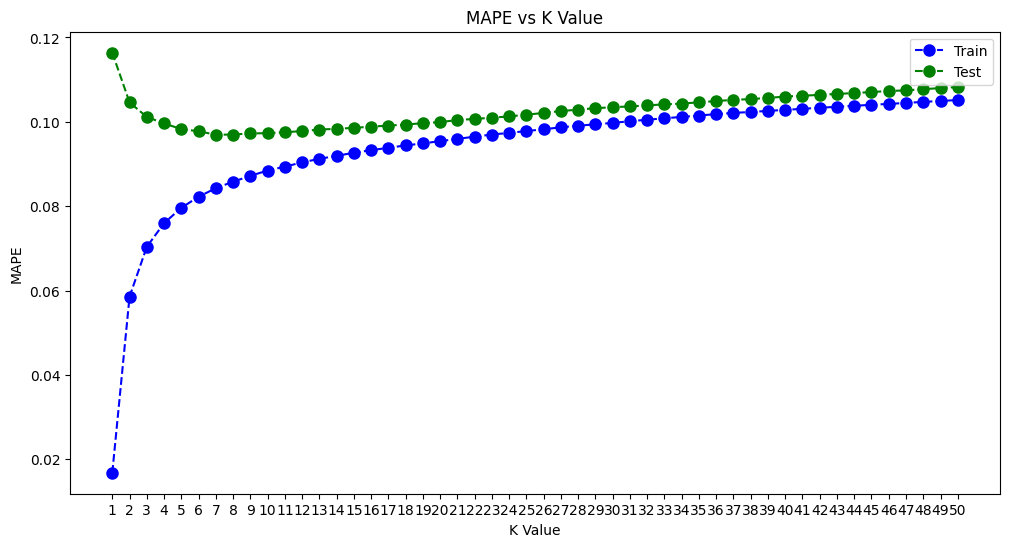

In [ ]:
K_start = 1
K_end = 50
mape_tr = []
mape_te = []
for i in range(K_start, K_end+1):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(xn_train, y_train)
    pred_i_tr = knn.predict(xn_train)
    pred_i_te = knn.predict(xn_test)
    mape_tr.append(metrics.mean_absolute_percentage_error(y_train,pred_i_tr))
    mape_te.append(metrics.mean_absolute_percentage_error(y_test,pred_i_te))

### Plot for testing k that appropriate
plt.figure(figsize=(12, 6))
plt.plot(range(K_start, K_end+1), mape_tr, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=8,label="Train")
plt.plot(range(K_start, K_end+1), mape_te, color='green', linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=8,label="Test")
plt.legend()
plt.xticks(np.arange(K_start, K_end+1, 1))
plt.title('MAPE vs K Value')
plt.xlabel('K Value')
plt.ylabel('MAPE')
plt.show()

# k = 2-25

In [ ]:
model_knn = KNeighborsRegressor()

In [ ]:
# Hyper parameters range intialization for tuning
parameters={"n_neighbors" : list(range(2,25)),}

In [ ]:
tuning_model_knn=GridSearchCV(model_knn,
                              param_grid=parameters,
                              scoring='neg_mean_absolute_error',
                              cv=5, verbose=3)

In [ ]:
tuning_model_knn.fit(x_train,y_train)

Fitting 5 folds for each of 23 candidates, totalling 115 fits
[CV 1/5] END ..................n_neighbors=2;, score=-363.137 total time=   0.2s
[CV 2/5] END ..................n_neighbors=2;, score=-369.972 total time=   0.2s
[CV 3/5] END ..................n_neighbors=2;, score=-366.920 total time=   0.2s
[CV 4/5] END ..................n_neighbors=2;, score=-359.222 total time=   0.2s
[CV 5/5] END ..................n_neighbors=2;, score=-357.922 total time=   0.2s
[CV 1/5] END ..................n_neighbors=3;, score=-351.773 total time=   0.2s
[CV 2/5] END ..................n_neighbors=3;, score=-355.567 total time=   0.2s
[CV 3/5] END ..................n_neighbors=3;, score=-353.772 total time=   0.2s
[CV 4/5] END ..................n_neighbors=3;, score=-346.614 total time=   0.2s
[CV 5/5] END ..................n_neighbors=3;, score=-343.305 total time=   0.2s
[CV 1/5] END ..................n_neighbors=4;, score=-346.404 total time=   0.2s
[CV 2/5] END ..................n_neighbors=4;, 

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24]},
             scoring='neg_mean_absolute_error', verbose=3)

In [ ]:
# best hyperparameters
print("Best hyperparameters:", tuning_model_knn.best_params_)
print("Best score:", tuning_model_knn.best_score_)

Best hyperparameters: {'n_neighbors': 7}
Best score: -338.45369487014943


In [ ]:
model_knn_final = KNeighborsRegressor(n_neighbors=7)
model_knn_final.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=7)

In [ ]:
# Predict the labels for the test data using the best model
y_pred_train_knn = model_knn_final.predict(x_train)
y_pred_test_knn = model_knn_final.predict(x_test)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_train,y_pred_train_knn))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_train_knn))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_knn)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_train, y_pred_train_knn))

MAE: 284.5441272707043
MSE: 152033.3221529865
RMSE: 389.9145062099979
MAPE: 0.08427093261846444


In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test,y_pred_test_knn))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test_knn))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_knn)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred_test_knn))

MAE: 327.667011515027
MSE: 204064.92852755025
RMSE: 451.73546299526924
MAPE: 0.09693333274678868


In [ ]:
print('Target classes of the first 10 rows are {}'.format(y_test.values[0:10]))
print('Predicted classes of the first 10 rows are {}'.format(y_pred_test_knn[0:10]))

Target classes of the first 10 rows are [[1812.5       ]
 [2281.39534884]
 [2304.        ]
 [5119.2       ]
 [5346.55172414]
 [2906.4516129 ]
 [4312.02531646]
 [2664.40677966]
 [4723.63636364]
 [7175.72815534]]
Predicted classes of the first 10 rows are [[1870.44425087]
 [2369.99432785]
 [2284.84011962]
 [4426.23151453]
 [5263.34628564]
 [3173.27572965]
 [5783.54287714]
 [2832.94289807]
 [4768.94382686]
 [7104.60878766]]


# Random  Undersampling

In [ ]:
# displaying the datatypes
display(y_train.dtypes)

y_train_int = y_train

# converting 'Weight' from float to int
y_train_int['ppc'] = y_train_int['ppc'].astype(int)

# displaying the datatypes
display(y_train_int.dtypes)

ppc    float64
dtype: object

ppc    int64
dtype: object

In [ ]:
rus = RandomUnderSampler(random_state=1234)
xrus_train, yrus_train = rus.fit_resample(x_train, y_train_int)

print(xrus_train.shape)
print(yrus_train.shape)

(5733, 6)
(5733, 1)


In [ ]:
5733/53940

# 5733/53940 = 10.63%

0.10628476084538376

(array([1051.  , 1414.55, 1778.1 , 2141.65, 2505.2 , 2868.75, 3232.3 ,
        3595.85, 3959.4 , 4322.95, 4686.5 , 5050.05, 5413.6 , 5777.15,
        6140.7 , 6504.25, 6867.8 , 7231.35, 7594.9 , 7958.45, 8322.  ]),
 array([109., 302., 327., 345., 341., 357., 349., 351., 350., 348., 333.,
        314., 280., 270., 262., 230., 247., 224., 207., 187.]))

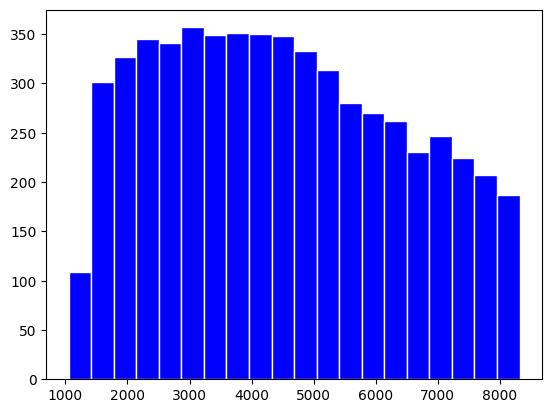

In [ ]:
n, bins, patches = plt.hist(yrus_train['ppc'], bins=20,color='blue', ec='white')
bins, n

# Modeling After Undersampling

## Decision Tree Regressor

In [ ]:
featurename = xrus_train.columns
model_dt_rus = DecisionTreeRegressor(criterion='absolute_error',
                                     splitter='best',
                                     random_state=1234)
model_dt_rus.fit(xrus_train, yrus_train)

DecisionTreeRegressor(criterion='absolute_error', random_state=1234)

In [ ]:
text_representation = tree.export_text(model_dt_rus, feature_names=list(featurename))
print(text_representation)

# maxdept = 11+18= 29

|--- carat <= 0.87
|   |--- carat <= 0.47
|   |   |--- nclarity <= 5.50
|   |   |   |--- ncolor <= 0.97
|   |   |   |   |--- carat <= 0.38
|   |   |   |   |   |--- ncolor <= 0.94
|   |   |   |   |   |   |--- nclarity <= 3.50
|   |   |   |   |   |   |   |--- ncut <= 4.50
|   |   |   |   |   |   |   |   |--- depth <= 63.70
|   |   |   |   |   |   |   |   |   |--- carat <= 0.31
|   |   |   |   |   |   |   |   |   |   |--- value: [1170.00]
|   |   |   |   |   |   |   |   |   |--- carat >  0.31
|   |   |   |   |   |   |   |   |   |   |--- ncut <= 2.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- ncut >  2.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |--- depth >  63.70
|   |   |   |   |   |   |   |   |   |--- value: [1130.00]
|   |   |   |   |   |   |   |--- ncut >  4.50
|   |   |   |   |   |   |   |   |--- nclarity <= 2.50
|   |   |   |   |   |   |

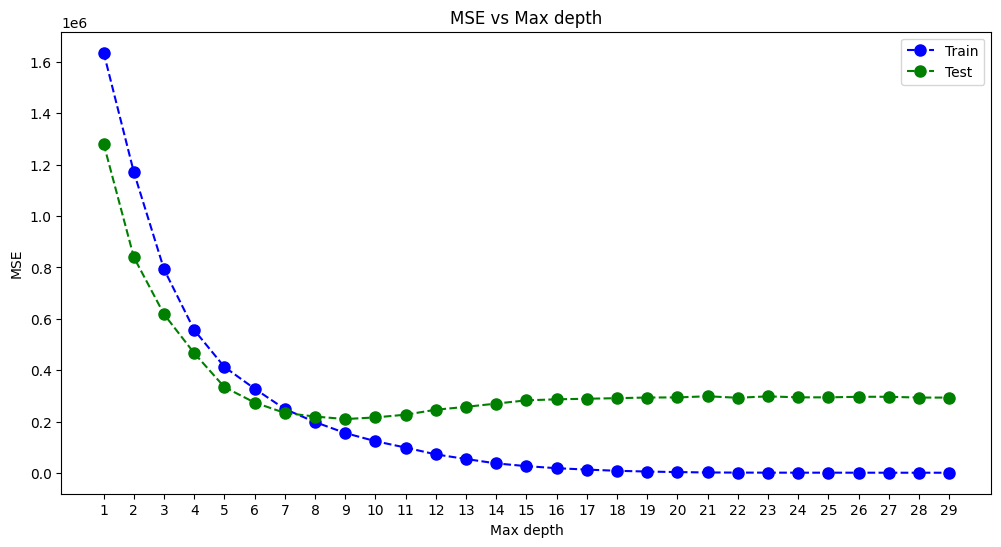

In [ ]:
max_depth_start = 1
max_depth_end = 29
mse_tr = []
mse_te = []

for i in range(max_depth_start, max_depth_end+1):
    dt = DecisionTreeRegressor(criterion='absolute_error',
                               splitter='best',
                               random_state=1234,
                               max_depth=i)
    dt.fit(xrus_train, yrus_train)
    pred_i_tr = dt.predict(xrus_train)
    pred_i_te = dt.predict(x_test)
    mse_tr.append(metrics.mean_squared_error(yrus_train, pred_i_tr))
    mse_te.append(metrics.mean_squared_error(y_test, pred_i_te))

### Plot for testing max_depth that appropriate
plt.figure(figsize=(12, 6))
plt.plot(range(max_depth_start, max_depth_end+1), mse_tr, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=8,label="Train")
plt.plot(range(max_depth_start, max_depth_end+1), mse_te, color='green', linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=8,label="Test")
plt.legend()
plt.xticks(np.arange(max_depth_start, max_depth_end+1, 1))
plt.title('MSE vs Max depth')
plt.xlabel('Max depth')
plt.ylabel('MSE')
plt.show()

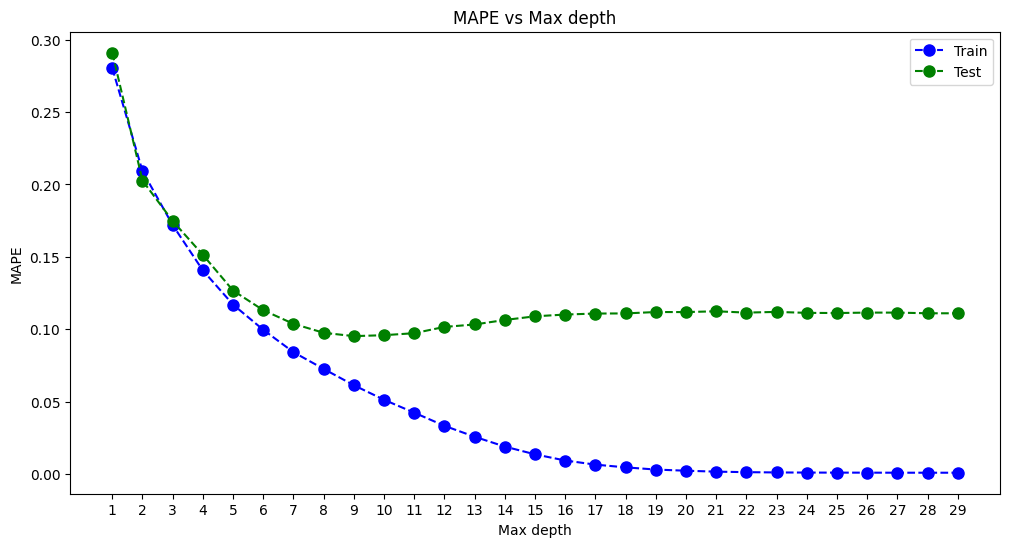

In [ ]:
max_depth_start = 1
max_depth_end = 29
mape_tr = []
mape_te = []

for i in range(max_depth_start, max_depth_end+1):
    dt = DecisionTreeRegressor(criterion='absolute_error',
                               splitter='best',
                               random_state=1234,
                               max_depth=i)
    dt.fit(xrus_train, yrus_train)
    pred_i_tr = dt.predict(xrus_train)
    pred_i_te = dt.predict(x_test)
    mape_tr.append(metrics.mean_absolute_percentage_error(yrus_train, pred_i_tr))
    mape_te.append(metrics.mean_absolute_percentage_error(y_test, pred_i_te))

### Plot for testing max_depth that appropriate
plt.figure(figsize=(12, 6))
plt.plot(range(max_depth_start, max_depth_end+1), mape_tr, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=8,label="Train")
plt.plot(range(max_depth_start, max_depth_end+1), mape_te, color='green', linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=8,label="Test")
plt.legend()
plt.xticks(np.arange(max_depth_start, max_depth_end+1, 1))
plt.title('MAPE vs Max depth')
plt.xlabel('Max depth')
plt.ylabel('MAPE')
plt.show()

#choose 3-12

In [ ]:
model_dt = DecisionTreeRegressor(criterion='absolute_error',
                                 splitter='best', random_state=1234)

In [ ]:
# Hyper parameters range intialization for tuning
parameters={"max_depth" : [3,4,5,6,7,8,9,10,11,12],
            "min_samples_split":[60,120,180,240,300],
            "min_samples_leaf":[60,120,180,240,300],
            }

In [ ]:
tuning_model_dt=GridSearchCV(model_dt,
                              param_grid=parameters,
                             scoring='neg_mean_absolute_error',
                              cv=5, verbose=3)

In [ ]:
tuning_model_dt.fit(xrus_train,yrus_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV 1/5] END max_depth=3, min_samples_leaf=60, min_samples_split=60;, score=-1112.041 total time=   1.0s
[CV 2/5] END max_depth=3, min_samples_leaf=60, min_samples_split=60;, score=-1084.203 total time=   0.7s
[CV 3/5] END max_depth=3, min_samples_leaf=60, min_samples_split=60;, score=-1134.989 total time=   0.5s
[CV 4/5] END max_depth=3, min_samples_leaf=60, min_samples_split=60;, score=-1473.106 total time=   0.4s
[CV 5/5] END max_depth=3, min_samples_leaf=60, min_samples_split=60;, score=-1982.653 total time=   0.3s
[CV 1/5] END max_depth=3, min_samples_leaf=60, min_samples_split=120;, score=-1112.041 total time=   0.4s
[CV 2/5] END max_depth=3, min_samples_leaf=60, min_samples_split=120;, score=-1084.203 total time=   0.3s
[CV 3/5] END max_depth=3, min_samples_leaf=60, min_samples_split=120;, score=-1134.989 total time=   0.2s
[CV 4/5] END max_depth=3, min_samples_leaf=60, min_samples_split=120;, score=-1473.106 total 

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(criterion='absolute_error',
                                             random_state=1234),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'min_samples_leaf': [60, 120, 180, 240, 300],
                         'min_samples_split': [60, 120, 180, 240, 300]},
             scoring='neg_mean_absolute_error', verbose=3)

In [ ]:
# best hyperparameters
print("Best hyperparameters:", tuning_model_dt.best_params_)
print("Best score:", tuning_model_dt.best_score_)

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 60, 'min_samples_split': 60}
Best score: -1012.4075514545115


In [ ]:
model_dt_final = DecisionTreeRegressor(criterion='absolute_error',
                                       splitter='best',
                                       random_state= 1234,
                                       min_samples_split=60,
                                       min_samples_leaf=60,
                                       max_depth=10,)
model_dt_final.fit(xrus_train, yrus_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                      min_samples_leaf=60, min_samples_split=60,
                      random_state=1234)

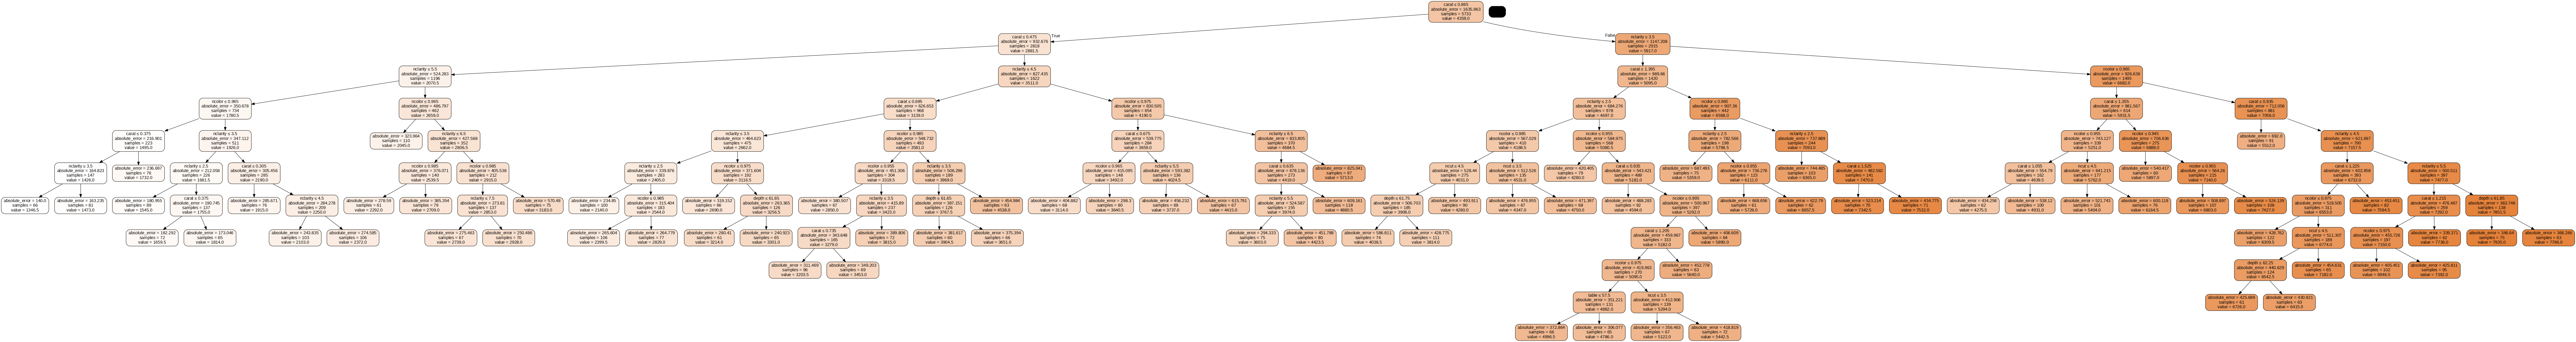

In [ ]:
Tree_visulization(model_dt_final)

In [ ]:
# Predict the labels for the test data using the best model
y_pred_train_dt = model_dt_final.predict(xrus_train)
y_pred_test_dt = model_dt_final.predict(x_test)

In [ ]:
print('MAE:', metrics.mean_absolute_error(yrus_train,y_pred_train_dt))
print('MSE:', metrics.mean_squared_error(yrus_train, y_pred_train_dt))
print('RMSE:', np.sqrt(metrics.mean_squared_error(yrus_train, y_pred_train_dt)))
print('MAPE:', metrics.mean_absolute_percentage_error(yrus_train, y_pred_train_dt))

MAE: 414.83847898133615
MSE: 330671.83036804467
RMSE: 575.0407206172835
MAPE: 0.1011124417864383


In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test,y_pred_test_dt))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test_dt))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_dt)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred_test_dt))

MAE: 390.88128615762747
MSE: 284348.2845269682
RMSE: 533.2431757903407
MAPE: 0.11566448664304947


In [ ]:
print('Target classes of the first 10 rows are {}'.format(y_test.values[0:10]))
print('Predicted classes of the first 10 rows are {}'.format(y_pred_test_dt[0:10]))

Target classes of the first 10 rows are [[1812.5       ]
 [2281.39534884]
 [2304.        ]
 [5119.2       ]
 [5346.55172414]
 [2906.4516129 ]
 [4312.02531646]
 [2664.40677966]
 [4723.63636364]
 [7175.72815534]]
Predicted classes of the first 10 rows are [1814.  2103.  2292.  4038.5 5404.  2928.  6365.  2140.  4931.  6946.5]


## K-Nearest Neighbor Regressor

### Normalization

In [ ]:
#x' = (x – min) / (max – min)

scaler = MinMaxScaler()
featurename = x.columns
xnrus_train = xrus_train
xn_test = x_test

for col in featurename:
  xnrus_train[col] = scaler.fit_transform(xnrus_train[[col]])

for col in featurename:
  xn_test[col] = scaler.fit_transform(xn_test[[col]])

In [ ]:
xnrus_train.describe()

carat        depth        table     nclarity         ncut  \
count  5733.000000  5733.000000  5733.000000  5733.000000  5733.000000   
mean      0.373244     0.492618     0.493037     0.442301     0.745421   
std       0.231021     0.195070     0.182053     0.230249     0.265054   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.177778     0.375000     0.385965     0.285714     0.500000   
50%       0.388889     0.500000     0.473684     0.428571     0.750000   
75%       0.516667     0.607143     0.649123     0.571429     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            ncolor  
count  5733.000000  
mean      0.557242  
std       0.286186  
min       0.000000  
25%       0.333333  
50%       0.500000  
75%       0.833333  
max       1.000000

In [ ]:
xn_test.describe()

carat        depth        table     nclarity         ncut  \
count  9372.000000  9372.000000  9372.000000  9372.000000  9372.000000   
mean      0.281923     0.501359     0.455001     0.440994     0.755842   
std       0.212729     0.192598     0.176518     0.231875     0.253535   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.094444     0.375000     0.347826     0.285714     0.500000   
50%       0.216667     0.517857     0.434783     0.428571     0.750000   
75%       0.450000     0.625000     0.608696     0.571429     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

            ncolor  
count  9372.000000  
mean      0.575384  
std       0.281883  
min       0.000000  
25%       0.333333  
50%       0.500000  
75%       0.833333  
max       1.000000

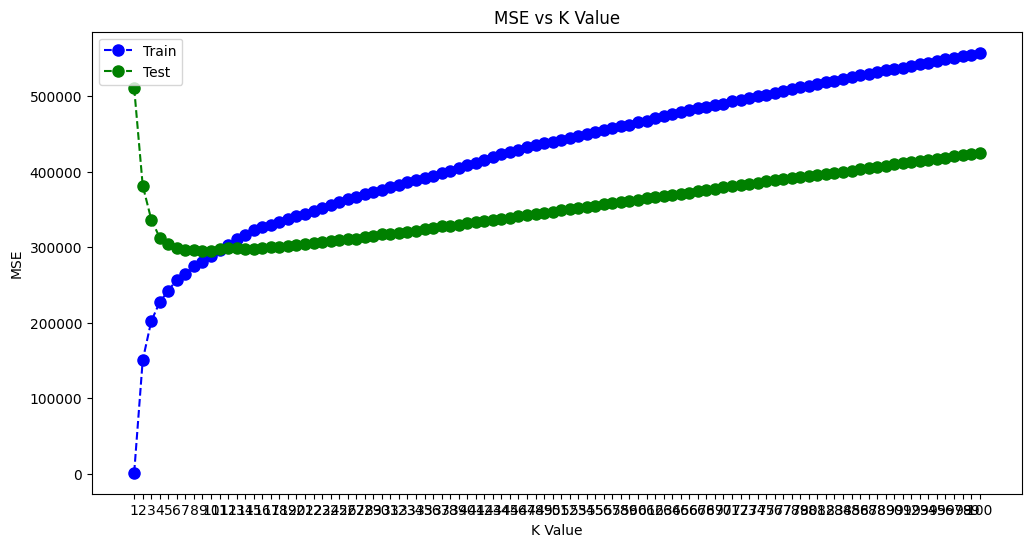

In [ ]:
K_start = 1
K_end = 100
mse_tr = []
mse_te = []
for i in range(K_start, K_end+1):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(xnrus_train, yrus_train)
    pred_i_tr = knn.predict(xnrus_train)
    pred_i_te = knn.predict(xn_test)
    mse_tr.append(metrics.mean_squared_error(yrus_train,pred_i_tr))
    mse_te.append(metrics.mean_squared_error(y_test,pred_i_te))

### Plot for testing k that appropriate
plt.figure(figsize=(12, 6))
plt.plot(range(K_start, K_end+1), mse_tr, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=8,label="Train")
plt.plot(range(K_start, K_end+1), mse_te, color='green', linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=8,label="Test")
plt.legend()
plt.xticks(np.arange(K_start, K_end+1, 1))
plt.title('MSE vs K Value')
plt.xlabel('K Value')
plt.ylabel('MSE')
plt.show()

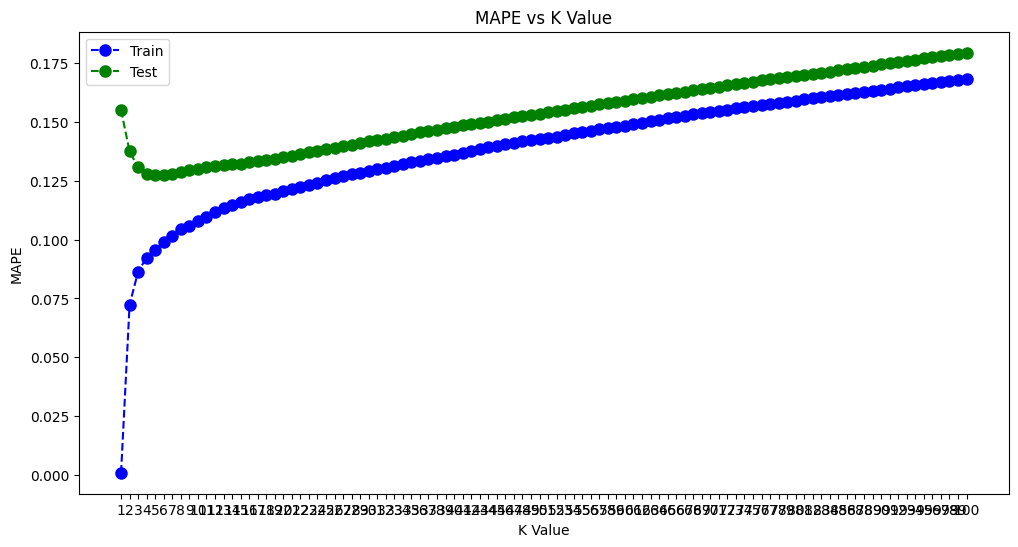

In [ ]:
K_start = 1
K_end = 100
mape_tr = []
mape_te = []
for i in range(K_start, K_end+1):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(xnrus_train, yrus_train)
    pred_i_tr = knn.predict(xnrus_train)
    pred_i_te = knn.predict(xn_test)
    mape_tr.append(metrics.mean_absolute_percentage_error(yrus_train,pred_i_tr))
    mape_te.append(metrics.mean_absolute_percentage_error(y_test,pred_i_te))

### Plot for testing k that appropriate
plt.figure(figsize=(12, 6))
plt.plot(range(K_start, K_end+1), mape_tr, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=8,label="Train")
plt.plot(range(K_start, K_end+1), mape_te, color='green', linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=8,label="Test")
plt.legend()
plt.xticks(np.arange(K_start, K_end+1, 1))
plt.title('MAPE vs K Value')
plt.xlabel('K Value')
plt.ylabel('MAPE')
plt.show()

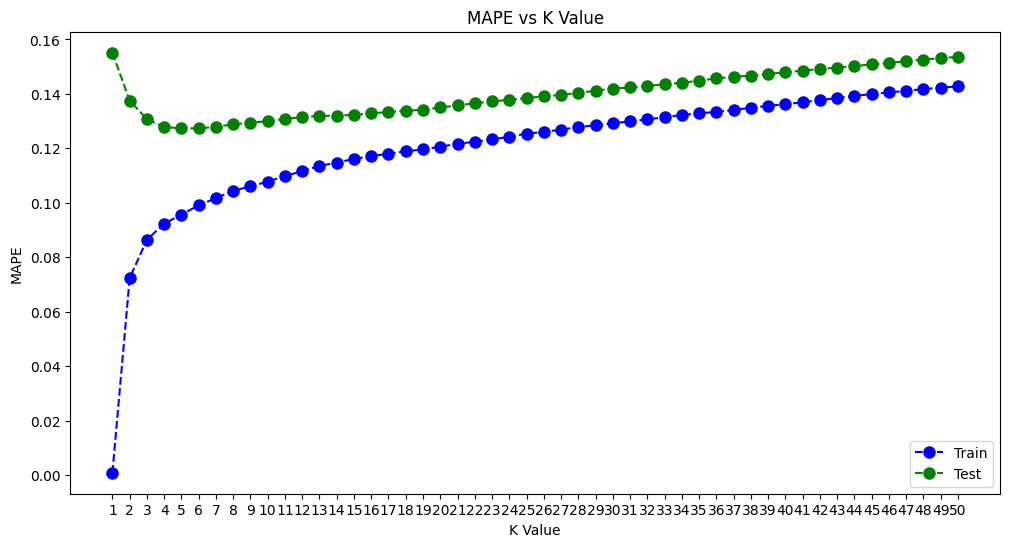

In [ ]:
K_start = 1
K_end = 50
mape_tr = []
mape_te = []
for i in range(K_start, K_end+1):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(xnrus_train, yrus_train)
    pred_i_tr = knn.predict(xnrus_train)
    pred_i_te = knn.predict(xn_test)
    mape_tr.append(metrics.mean_absolute_percentage_error(yrus_train,pred_i_tr))
    mape_te.append(metrics.mean_absolute_percentage_error(y_test,pred_i_te))

### Plot for testing k that appropriate
plt.figure(figsize=(12, 6))
plt.plot(range(K_start, K_end+1), mape_tr, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=8,label="Train")
plt.plot(range(K_start, K_end+1), mape_te, color='green', linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=8,label="Test")
plt.legend()
plt.xticks(np.arange(K_start, K_end+1, 1))
plt.title('MAPE vs K Value')
plt.xlabel('K Value')
plt.ylabel('MAPE')
plt.show()

# k = 2-25

In [ ]:
model_knn = KNeighborsRegressor()

In [ ]:
# Hyper parameters range intialization for tuning
parameters={"n_neighbors" : list(range(2,25)),}

In [ ]:
tuning_model_knn=GridSearchCV(model_knn,
                              param_grid=parameters,
                              scoring='neg_mean_absolute_error',
                              cv=5, verbose=3)

In [ ]:
tuning_model_knn.fit(xnrus_train,yrus_train)

Fitting 5 folds for each of 23 candidates, totalling 115 fits
[CV 1/5] END .................n_neighbors=2;, score=-1157.890 total time=   0.0s
[CV 2/5] END ..................n_neighbors=2;, score=-822.203 total time=   0.0s
[CV 3/5] END ..................n_neighbors=2;, score=-830.843 total time=   0.0s
[CV 4/5] END ..................n_neighbors=2;, score=-896.383 total time=   0.0s
[CV 5/5] END .................n_neighbors=2;, score=-1552.677 total time=   0.0s
[CV 1/5] END .................n_neighbors=3;, score=-1188.768 total time=   0.0s
[CV 2/5] END ..................n_neighbors=3;, score=-758.539 total time=   0.0s
[CV 3/5] END ..................n_neighbors=3;, score=-781.157 total time=   0.0s
[CV 4/5] END ..................n_neighbors=3;, score=-826.587 total time=   0.0s
[CV 5/5] END .................n_neighbors=3;, score=-1592.671 total time=   0.0s
[CV 1/5] END .................n_neighbors=4;, score=-1218.784 total time=   0.0s
[CV 2/5] END ..................n_neighbors=4;, 

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24]},
             scoring='neg_mean_absolute_error', verbose=3)

In [ ]:
# best hyperparameters
print("Best hyperparameters:", tuning_model_knn.best_params_)
print("Best score:", tuning_model_knn.best_score_)

Best hyperparameters: {'n_neighbors': 8}
Best score: -1002.37733616491


In [ ]:
model_knn_final = KNeighborsRegressor(n_neighbors=8)
model_knn_final.fit(xnrus_train, yrus_train)

KNeighborsRegressor(n_neighbors=8)

In [ ]:
# Predict the labels for the test data using the best model
y_pred_train_knn = model_knn_final.predict(xnrus_train)
y_pred_test_knn = model_knn_final.predict(xn_test)

In [ ]:
print('MAE:', metrics.mean_absolute_error(yrus_train,y_pred_train_knn))
print('MSE:', metrics.mean_squared_error(yrus_train, y_pred_train_knn))
print('RMSE:', np.sqrt(metrics.mean_squared_error(yrus_train, y_pred_train_knn)))
print('MAPE:', metrics.mean_absolute_percentage_error(yrus_train, y_pred_train_knn))

MAE: 397.1898656898657
MSE: 274652.1865297401
RMSE: 524.072692028253
MAPE: 0.1044520038283846


In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test,y_pred_test_knn))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test_knn))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_knn)))
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred_test_knn))

MAE: 411.6205304725772
MSE: 295845.92692813877
RMSE: 543.9172059497096
MAPE: 0.12879661667213


In [ ]:
print('Target classes of the first 10 rows are {}'.format(y_test.values[0:10]))
print('Predicted classes of the first 10 rows are {}'.format(y_pred_test_knn[0:10]))

Target classes of the first 10 rows are [[1812.5       ]
 [2281.39534884]
 [2304.        ]
 [5119.2       ]
 [5346.55172414]
 [2906.4516129 ]
 [4312.02531646]
 [2664.40677966]
 [4723.63636364]
 [7175.72815534]]
Predicted classes of the first 10 rows are [[2252.75 ]
 [2440.125]
 [2554.125]
 [4409.625]
 [5030.625]
 [3456.25 ]
 [6213.   ]
 [3147.375]
 [5186.875]
 [7149.125]]


# Summary

In [ ]:
score =
    'name': ['MAE','MSE','RMSE' ,'MAPE'],
    'Decision Tree Regressor round1': [461.3489,414190.1028, 643.5760, 0.1290],
    'Decision Tree Regressor round2': [419.9244,343712.4128,586.2699, 0.1187],
    'Decision Tree Regressor with Undersampling':[390.8813,234348.2845,533.2432,0.1157] ,
    'K-Nearest Neighbors Regressor': [327.6670,204064.9285,451.7355,0.0969],
    'K-Nearest Neighbors Regressor with Undersampling': [411.6205, 295845.9269, 543.9172, 0.1288]
    }

df_score = pd.DataFrame(data=score, index=['MAE','MSE','RMSE' ,'MAPE'])

df_score = df_score.set_index('name')
df_score.T

name                                                   MAE          MSE  \
Decision Tree Regressor round1                    461.3489  414190.1028   
Decision Tree Regressor round2                    419.9244  343712.4128   
Decision Tree Regressor with Undersampling        390.8813  234348.2845   
K-Nearest Neighbors Regressor                     327.6670  204064.9285   
K-Nearest Neighbors Regressor with Undersampling  411.6205  295845.9269   

name                                                  RMSE    MAPE  
Decision Tree Regressor round1                    643.5760  0.1290  
Decision Tree Regressor round2                    586.2699  0.1187  
Decision Tree Regressor with Undersampling        533.2432  0.1157  
K-Nearest Neighbors Regressor                     451.7355  0.0969  
K-Nearest Neighbors Regressor with Undersampling  543.9172  0.1288

Selected Model: K Neighbors Regressor

Influenced feature: Carat, Clarity, Color







# Member
1. 6442003826 กฤตพร อุ่นยวง
2. 6442015326 ชวัลลักษณ์ สุขชื่น
3. 6442090326 ยศพนธ์ เพียรศรีวัชรา
4. 6442113126 สุชานันท์ คุตชนม์
5. 6442127026 อารียา ทัตตินาพานิช